In [13]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

sys.path.insert(0, '../')
sys.path.insert(0, '../wilds_source/')

from relative_prevalence_benchmark.gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('0')

import torch
from torch import nn

from wilds_source.wilds import get_dataset
from wilds_source.wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds_source.wilds.common.grouper import CombinatorialGrouper

import torch
import torchvision.transforms as transforms
from torch import nn

from tqdm.notebook import tqdm

sys.path.insert(0, '../wilds_source/examples/')
from transforms import initialize_transform, getBertTokenizer
from algorithms.initializer import initialize_algorithm

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU:0


### Load original dataset

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test_public_expanded.csv')
individual_annotations = pd.read_csv('../data/toxicity_individual_annotations.csv')

train = train[train['identity_annotator_count'] > 0]
test = test[test['identity_annotator_count'] > 0]
# 20% of the comments are annotated for identity, and these are the comments we want

In [4]:
one_annotation = individual_annotations.groupby('id').first().reset_index()
all_annotations = individual_annotations.groupby('id').mean().reset_index()

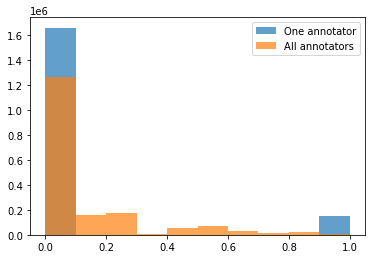

In [5]:
plt.hist(one_annotation['toxic'], alpha=.7, label='One annotator')
plt.hist(all_annotations['toxic'], alpha=.7, label='All annotators')
plt.legend()

### Table of example comments

In [6]:
identities = ['asian', 'atheist', 'bisexual',
               'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
               'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
               'jewish', 'latino', 'male', 'muslim', 'other_disability',
               'other_gender', 'other_race_or_ethnicity', 'other_religion',
               'other_sexual_orientation', 'physical_disability',
               'psychiatric_or_mental_illness', 'transgender', 'white']
train['n_identities'] = (train[identities] > 0).sum(axis=1)
train = train[~train['comment_text'].str.contains('http')]

In [7]:
nontoxic_train = train[train['target']  < .5]
toxic_train = train[train['target'] > .5]

nontoxic_train_no_identities = nontoxic_train[nontoxic_train['n_identities'] == 0]
nontoxic_train_w_identities = nontoxic_train[nontoxic_train['n_identities'] > 1]
toxic_train_no_identities =  toxic_train[toxic_train['n_identities'] == 0]
toxic_train_one_identity =  toxic_train[toxic_train['n_identities'] == 1]
toxic_train_mult_identities = toxic_train[toxic_train['n_identities'] >1]


In [104]:
def map_row_to_identities_list(row):
    included_identities = ""
    for identity in identities:
        if row[identity] > 0:
            included_identities += (identity.replace('_', ' ')) + ","
    if len(included_identities):
        return included_identities[:-1]
    return included_identities

In [105]:
n_to_sample, seed = 3, 99
a = nontoxic_train_no_identities.sample(n=n_to_sample, random_state=seed)
b = nontoxic_train_w_identities.sample(n=n_to_sample, random_state=seed)
c = toxic_train_no_identities.sample(n=n_to_sample, random_state=seed)
d = toxic_train_one_identity.sample(n=n_to_sample, random_state=seed)
e =  toxic_train_mult_identities.sample(n=n_to_sample, random_state=seed)

kk = pd.concat([a, b, c, d, e])
kk['identities_list'] = kk.apply(map_row_to_identities_list, axis=1)
kk['toxicity'] = kk['target'] > .5
kk['toxicity'] = kk['toxicity'].astype(int)
kk['comment_text_pref'] = kk['comment_text'].str[:150] + "..."
kk = kk[['comment_text_pref', 'toxicity', 'identities_list']]
kk.rename(columns = {'comment_text_pref': 'Comment Text', 
                     'toxicity': 'Toxicity',  
                     'identities_list': 'List of Identities'}, inplace=True)

In [106]:
with pd.option_context("max_colwidth", 1000):

    latex_str = kk.to_latex(escape=False,  index=False, column_format='p{0.5\linewidth}|c|r}')
    print(latex_str)

\begin{tabular}{p{0.5\linewidth}|c|r}}
\toprule
                                                                                                                                                Comment Text &  Toxicity &               List of Identities \\
\midrule
 Donald Trump is an American, living in American, and  paying taxes under the American system- please try and keep up.\n\nStrangely enough, when I got my... &         0 &                                  \\
   "There are even some places (a McDonald’s in Kaneohe was one) who have entire employee-application booths set up right there, like the ones at job fai... &         0 &                                  \\
                                     Hunting is a long walk on an empty stomach, glad to hear your hunt is over and your heart and stomach are both full.... &         0 &                                  \\
   I can't think of anyone less Christian than Trump. Anyone who puts the bottom line ahead of the welfare of their

### Apply pretrained model to this dataset

In [15]:
thresh = .5
full_dataset = get_dataset(dataset='civilcomments', download=True)
   
config_dict = pickle.load(open('./cc_config.pkl', 'rb'))
config = Namespace(**config_dict)
config.algorithm = 'ERM'

train_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=True)
eval_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=False)

In [4]:
# text_str = ""
# def get_idx_in_text_array(full_dataset, substr):
#     text_array = full_dataset._text_array
#     idxs = [i for i in range(len(text_array)) if substr in text_array[i]]
#     if len(idxs):
#         return idxs[0]
#     return 0
# idx = get_idx_in_text_array(full_dataset, text_str)
# full_dataset._y_array[idx]

In [17]:
data = full_dataset.get_subset('test', transform=eval_transform)
data_loader = get_eval_loader('standard', data, batch_size=8)

In [18]:
datasets = defaultdict(dict)
train_grouper = CombinatorialGrouper(dataset=full_dataset, groupby_fields=config.groupby_fields)
for split in full_dataset.split_dict.keys():
    if split=='train':
        transform = train_transform
        verbose = True
    elif split == 'val':
        transform = eval_transform
        verbose = True
    else:
        transform = eval_transform
        verbose = False
    # Get subset
    datasets[split]['dataset'] = full_dataset.get_subset(
        split,
        frac=config.frac,
        transform=transform)

    if split == 'train':
        datasets[split]['loader'] = get_train_loader(
            loader=config.train_loader,
            dataset=datasets[split]['dataset'],
            batch_size=config.batch_size,
            uniform_over_groups=config.uniform_over_groups,
            grouper=train_grouper,
            distinct_groups=config.distinct_groups,
            n_groups_per_batch=config.n_groups_per_batch,
        **config.loader_kwargs)
else:
    datasets[split]['loader'] = get_eval_loader(
        loader=config.eval_loader,
        dataset=datasets[split]['dataset'],
        grouper=train_grouper,
        batch_size=config.batch_size,
        **config.loader_kwargs)

# Set fields
datasets[split]['split'] = split
datasets[split]['name'] = full_dataset.split_names[split]
datasets[split]['verbose'] = verbose

In [20]:
# torch.save(alg.model)
alg.model

DistilBertClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [19]:
alg = initialize_algorithm(config, datasets, train_grouper)
alg.load_state_dict(torch.load('../best_model.pth')['algorithm'])
alg.model.cuda()
alg.model.eval()
alg.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN t

In [9]:
all_feats = []
metadata = []
all_labels = []
toxicity = []
it = iter(data_loader)
i = 0 
for batch in tqdm(it):
    i += 1
    jj = alg.model.distilbert(batch[0][:,:,0].cuda(), batch[0][:,:,1].cuda())['last_hidden_state']
    kk = jj[:,0].detach().cpu()
    all_feats.append(np.array(kk))
    all_labels.append(batch[1].cpu().numpy())
    metadata.append(batch[2].cpu().numpy())
    toxicity.append(batch[2].cpu().numpy()[:,-1])
all_feats = np.concatenate(all_feats, axis=0)
metadata = np.concatenate(metadata)
toxicity = np.concatenate(toxicity)
y = data.y_array

  0%|          | 0/16723 [00:00<?, ?it/s]

torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([

torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([

torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([

torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([8, 300, 768]) torch.Size([1, 300, 768])
torch.Size([

KeyboardInterrupt: 

In [ ]:
text = [full_dataset._text_array[i] for i in data.indices]

In [ ]:
annotations = full_dataset._metadata_fields
data_dir = '../data/real_true_labels/content_mod/' + str(thresh) + '/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

np.save(data_dir + '/vals.npz' , all_feats)
np.save(data_dir + '/metadata_col_names', annotations)
np.save(data_dir + '/metadata', metadata)
np.save(data_dir + '/toxicity', toxicity)
np.save(data_dir + '/observed_labels', y)
np.save(data_dir + '/text', text)

In [ ]:
len(text_reps), all_feats.shape

### Save version with a single annotator's label for toxicity